In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the original 4000-row training file
df = pd.read_csv('/content/drive/MyDrive/Speciale/randomsample_text_4000_train_labeled.csv')

print("Columns:", df.columns)

# Rename column
df = df.rename(columns={"chatgpt_score": "label"})

# Map string labels to integers
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["label"].map(label_map)

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]  # <- This ensures equal class distribution
)


Columns: Index(['text', 'source', 'chatgpt_score'], dtype='object')


In [6]:
from transformers import AutoTokenizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load roberta
model_name = "yiyanghkust/finbert-tone"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding="max_length",
    max_length=512
)

val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding="max_length",
    max_length=512
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [7]:
import torch

class FinbertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FinbertDataset(train_encodings, list(train_labels))
val_dataset = FinbertDataset(val_encodings, list(val_labels))

In [8]:
from transformers import TrainerCallback

class AccuracyLossLogger(TrainerCallback):
    def __init__(self):
        self.epoch_data = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_accuracy': [],
        }

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.epoch_data['epoch'].append(state.epoch)
        self.epoch_data['eval_loss'].append(metrics.get("eval_loss"))
        self.epoch_data['eval_accuracy'].append(metrics.get("eval_accuracy"))

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.epoch_data['train_loss'].append(logs["loss"])


In [9]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./finbert-finetuned",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=12,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # because lower loss is better
)


def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

logger_callback = AccuracyLossLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        logger_callback,
        EarlyStoppingCallback(early_stopping_patience=2)  # stops after 4 non-improving evals
    ]
)

trainer.train()

trainer.save_model("./finbert-finetuned")
tokenizer.save_pretrained("./finbert-finetuned")

# After training
trainer.save_model("/content/drive/MyDrive/Speciale/finbert-finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/Speciale/finbert-finetuned")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.738500,0.474814,0.912500,0.908591,0.917759,0.912500
2,0.244200,0.300373,0.927500,0.928305,0.930602,0.927500
3,0.106600,0.292657,0.946250,0.946216,0.946582,0.946250
4,0.035400,0.428829,0.941250,0.940935,0.941530,0.941250
5,0.012700,0.391794,0.946250,0.945895,0.945880,0.946250


('/content/drive/MyDrive/Speciale/finbert-finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/Speciale/finbert-finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/Speciale/finbert-finetuned/vocab.txt',
 '/content/drive/MyDrive/Speciale/finbert-finetuned/added_tokens.json',
 '/content/drive/MyDrive/Speciale/finbert-finetuned/tokenizer.json')

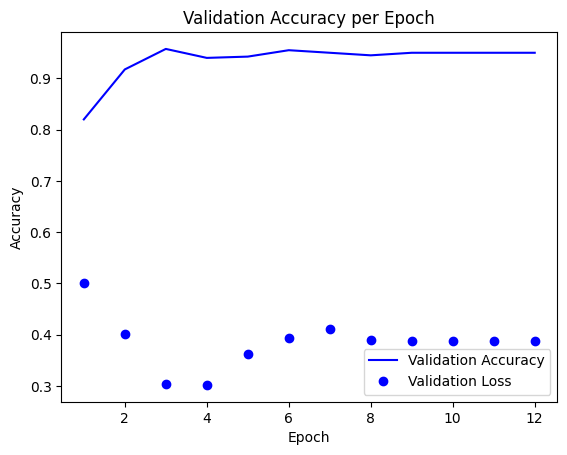

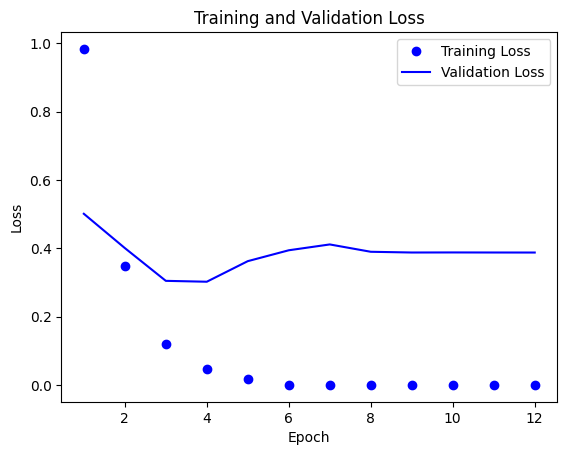

In [6]:
import matplotlib.pyplot as plt

epochs = logger_callback.epoch_data["epoch"]
train_loss = logger_callback.epoch_data["train_loss"]
eval_loss = logger_callback.epoch_data["eval_loss"]
eval_accuracy = logger_callback.epoch_data["eval_accuracy"]

# Accuracy plot
plt.plot(epochs, eval_accuracy, "b", label="Validation Accuracy")
plt.plot(range(1, len(eval_loss)+1), eval_loss, "bo", label="Validation Loss")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.plot(range(1, len(train_loss)+1), train_loss, "bo", label="Training Loss")
plt.plot(epochs, eval_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# model_path = "./finbert-finetuned"  # or your saved path

# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)
# model.eval()  # set to evaluation mode

model_path = "/content/drive/MyDrive/Speciale/finbert-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()




BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Speciale/sampled_text_4000_test.csv")
texts = df["text"].astype(str).tolist()


In [12]:
import torch
from tqdm import tqdm

# --- Batch settings ---
batch_size = 10  # Adjust to fit your GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Prepare model ---
model.to(device)
model.eval()

all_preds = []

# --- Batched inference ---
for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]

    encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )
    encodings = {k: v.to(device) for k, v in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=1).tolist()
        all_preds.extend(preds)

# --- Map to labels and assign to DataFrame ---
int_to_label = {0: "negative", 1: "neutral", 2: "positive"}
df["finbert_finetuned_score"] = [int_to_label[p] for p in all_preds]

df.to_csv("/content/drive/MyDrive/Speciale/newtext4000_with_finetuned_finbert.csv", index=False)


100%|██████████| 400/400 [00:11<00:00, 34.76it/s]


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load the true labels
df = pd.read_csv("/content/drive/MyDrive/Speciale/newtext4000_with_finetuned_finbert.csv")

# Optional: inspect column names
print(df.columns)
print(df.head(10))

# Map string labels to integers
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["true_label"] = df["chatgpt_score"].map(label_map)
df["predicted_label"] = df["finbert_finetuned_score"].map(label_map)

# Compute accuracy
accuracy = accuracy_score(df["true_label"], df["predicted_label"])
print(f"Finbert Accuracy: {accuracy:.4f}")

# Optional: full classification report
print("\nClassification Report:")
print(classification_report(df["true_label"], df["predicted_label"], target_names=label_map.keys()))


Index(['text', 'source', 'chatgpt_score', 'finbert_finetuned_score'], dtype='object')
                                                text      source  \
0  Wow. Began trading about 3 months ago, started...  submission   
1  Halting in Trading A genuine question many say...  submission   
2  i don't know what i'm doing but im winning i h...  submission   
3  Tommy going degen on QCOM puts Tommy Tubervill...  submission   
4              Zeugen Münzis Sind hier noch weitere?  submission   
5  Slna Selina Hospitality PLC  Just want to let ...  submission   
6  Journey so far Good 4 months so far imo. misse...  submission   
7  If Bryan Cohen Isn’t Filing A Form 4 Monday Th...  submission   
8  Tesla cuts 600 jobs in California amid mass la...  submission   
9  Nvidia Earnings Will it run for earnings & wha...  submission   

  chatgpt_score finbert_finetuned_score  
0      positive                 neutral  
1      negative                positive  
2      positive                 neutral

In [15]:
# To label submissions

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "/content/drive/MyDrive/Speciale/finbert-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

submissions = pd.read_csv("/content/drive/MyDrive/Speciale/submissions_with_roberta_sentiment.csv")
sub_texts = submissions["text"].astype(str).tolist()

# --- Batch processing ---
batch_size = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
all_preds = []

for i in tqdm(range(0, len(sub_texts), batch_size)):
    batch_texts = sub_texts[i:i+batch_size]

    encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    encodings = {k: v.to(device) for k, v in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=1).tolist()
        all_preds.extend(preds)

# --- Map to sentiment labels ---
int_to_label = {0: "negative", 1: "neutral", 2: "positive"}
submissions["finbert_finetuned_score"] = [int_to_label[p] for p in all_preds]

# --- Save to disk ---
submissions.to_csv("/content/drive/MyDrive/Speciale/submissions_with_finetuned_finbertnew.csv", index=False)


100%|██████████| 7281/7281 [05:12<00:00, 23.28it/s]


In [1]:
# To label comments

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# --- Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "/content/drive/MyDrive/Speciale/finbert-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# --- Load comments ---
comments = pd.read_csv("/content/drive/MyDrive/Speciale/comments_with_roberta_sentiment.csv")
com_texts = comments["text"].astype(str).tolist()

# --- Batch processing ---
batch_size = 10  # Adjust to 256 if you want faster processing and enough memory
all_preds = []

for i in tqdm(range(0, len(com_texts), batch_size)):
    batch_texts = com_texts[i:i+batch_size]

    encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )
    encodings = {k: v.to(device) for k, v in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=1).tolist()
        all_preds.extend(preds)

# --- Map to sentiment labels ---
int_to_label = {0: "negative", 1: "neutral", 2: "positive"}
comments["finbert_finetuned_score"] = [int_to_label[p] for p in all_preds]

# --- Save to disk ---
comments.to_csv("/content/drive/MyDrive/Speciale/comments_with_finetuned_finbert.csv", index=False)


100%|██████████| 4622/4622 [01:45<00:00, 43.65it/s]


In [2]:
import pandas as pd
from collections import Counter

# Define VADER label mapping
def vader_to_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Define consensus logic with tie-breaking
def compute_consensus(row):
    votes = [
        row['vader_label'],
        row['bert_sentiment_score'],
        row['roberta_sentiment_label'],
        row['finbert_finetuned_score']
    ]
    vote_counts = Counter(votes)
    top_two = vote_counts.most_common(2)

    if len(top_two) == 1 or top_two[0][1] > top_two[1][1]:
        return top_two[0][0]

    tied_labels = [label for label, count in top_two if count == 2]

    if "neutral" in tied_labels:
        if "positive" in tied_labels:
            return "positive"
        elif "negative" in tied_labels:
            return "negative"

    if set(tied_labels) == {"positive", "negative"}:
        return "positive"

    return top_two[0][0]

# Load CSV files
submissions_path = "/content/drive/MyDrive/Speciale/submissions_with_finetuned_finbert.csv"
comments_path = "/content/drive/MyDrive/Speciale/comments_with_finetuned_finbert.csv"

submissions_df = pd.read_csv(submissions_path)
comments_df = pd.read_csv(comments_path)

# Apply logic to both datasets
for df in [submissions_df, comments_df]:
    df['vader_label'] = df['vader_score'].apply(vader_to_label)
    df['consensus_score'] = df.apply(compute_consensus, axis=1)

# Save updated DataFrames
submissions_df.to_csv("/content/drive/MyDrive/Speciale/submissions_with_consensus.csv", index=False)
comments_df.to_csv("/content/drive/MyDrive/Speciale/comments_with_consensus.csv", index=False)